In [167]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import numpy as np
import gym
from gym.spaces import Discrete, Box
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [168]:
class Market(Env):
    def __init__(self, base_price, slope_demand, slope_competition) -> None:
        super().__init__()
        number_firms = 2
        self.action_space1 = Discrete(3, start=-1)
        self.action_space2 = Discrete(3, start=-1)
        self.observation_space1 = Box(low=0, high=10, dtype=np.float16)
        self.observation_space2 = Box(low=0, high=10, dtype=np.float16)
        self.number_firms = number_firms
        self.base_price = base_price
        self.slope_demand = slope_demand
        self.slope_competition = slope_competition
        self.prices = 5+np.random.random((number_firms))
        self.marginal_costs = np.array([1,2], dtype=float)
        self.quantities = np.zeros((number_firms))
        self.profits = np.zeros((number_firms))
        self.calculate_quantities()
        self.calculate_profits()
        self.t=0

    def calculate_profits(self):
        self.profits = self.prices*self.quantities - self.marginal_costs*self.quantities
    
    def calculate_quantities(self):
        for i in range(self.number_firms):
            self.quantities[i] = self.base_price \
                - self.slope_demand*self.prices[i] \
                + self.slope_competition*np.sum(self.prices) \
                - self.slope_competition*self.prices[i]
        # self.state = np.concatenate((self.prices, self.quantities, self.marginal_costs))
    
    def step(self, action1, action2):
        self.t+=1
        previous_profit = self.profits
        self.prices[0] += action1*0.1
        self.prices[1] += action2*0.1
        # add if price <= 0 , lower bound = 0 
        self.calculate_quantities()
        self.calculate_profits()
        new_profit = self.profits
        reward = new_profit-previous_profit
        return self.prices, reward, False, False, {}
    
    def reset(self):
        self.prices = 5+np.random.random((self.number_firms))
        self.marginal_costs = 1+np.random.random((self.number_firms))
        self.calculate_quantities()
        self.calculate_profits()
    
    def render(self):
        pass


In [169]:
# mlp for one agent

def mlp(sizes=[2,10,3], activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

In [170]:
firm1 = mlp()
firm2 = mlp()

firm1_optimizer = torch.optim.Adam(firm1.parameters(), lr=1e-4)

firm2_optimizer = torch.optim.Adam(firm2.parameters(), lr =1e-4)

In [171]:
def select_action(raw_output):
    probas = torch.nn.Softmax(dim=0)(raw_output).cpu()
    available_actions = [-1,0,1]
    action = torch.multinomial(probas, 1)
    return action - 1


In [172]:
a = torch.tensor([2.5,4,5])
select_action(a)

tensor([0])

In [173]:
# create an environmnet
# different mlps --> outcome into select_action
# you give the action to market and market will give you the new state and reward 
# you'll train to maximize reward 

In [174]:
market = Market(5, 0.3, 0.2)

prices_history = []

def train():
    for i in range(500000):
        
        prices_history.append(market.prices.copy())

        prices_tensor = torch.tensor(market.prices, dtype=torch.float32)

        p1 = firm1(prices_tensor)

        a1 = select_action(p1)

        p2 = firm2(prices_tensor)

        a2 = select_action(p2)

        prices, reward, _, _, _ =  market.step(a1,a2)

        def loss_function(p, r):
            return torch.sum((p-p.mean())*r)

        loss1 = loss_function(p1, reward[0])
        loss2 = loss_function(p2, reward[1])

        loss1.backward()
        loss2.backward()

        firm1_optimizer.step()
        firm1_optimizer.zero_grad()

        firm2_optimizer.step()
        firm2_optimizer.zero_grad()

In [192]:
training1 = train()

In [176]:
np.array(prices_history).shape

(50, 2)

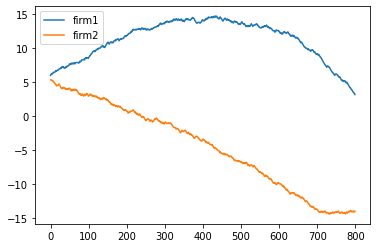

In [193]:
import matplotlib.pyplot as plt

prices_history_plot = np.array(prices_history)
prices_history_plot[:,0]
prices_history_plot[:,1]
plt.plot(prices_history_plot[:,0], label='firm1')
plt.plot(prices_history_plot[:,1], label='firm2')
plt.legend()
plt.show()


Next Steps
- set a 0 lower bound for price 
- revise input (pt and profit pt - profit pt-1)
- solve exercise by hand, compare 